##  <font color="green"> Importation de data </font> 

In [53]:

################################
import sys
import pandas as pd
from numpy import array
import matplotlib.pyplot as plt

df = pd.read_csv("data/hdf_desaisonalisé.csv", names=['value'], header=0)
# print(df)
print(df.head())

                           value
2012-12-31 00:00:00+00:00    NaN
2013-01-01 00:00:00+00:00    NaN
2013-01-02 00:00:00+00:00    NaN
2013-01-03 00:00:00+00:00    NaN
2013-01-04 00:00:00+00:00    NaN


##  <font color="green"> Traitement de l'information </font> 

In [54]:
#######################################
# checking for null values
print("null",df.isnull().sum())

df=df.dropna()
print(df.isnull().sum())

null value    364
dtype: int64
value    0
dtype: int64


##  <font color="green"> Vérifier la saisonnalité </font> 

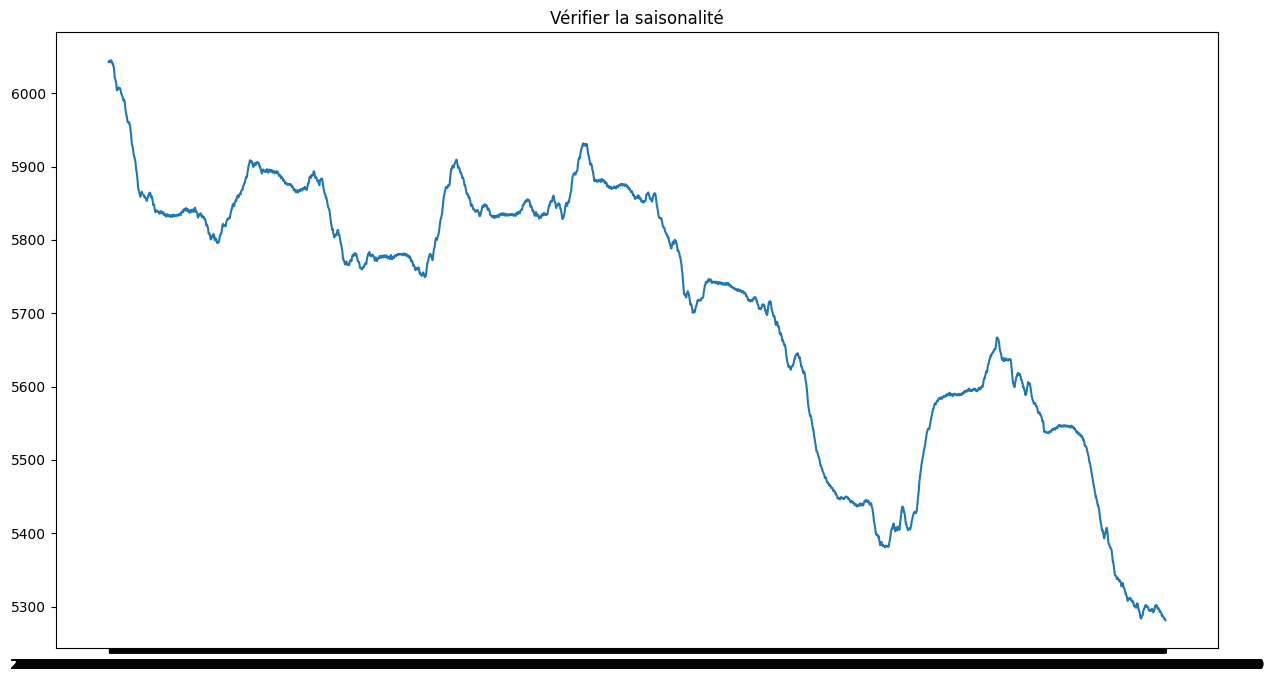

In [55]:
#####################################
# Plot Series
plt.figure(figsize=(15,8))
plt.plot(df.value)
plt.title("Vérifier la saisonalité")
plt.show()


### Le résultat montre qu'il y a une saisonnalité dans la série, le processus de différenciation doit être associé pour le supprimer.

##  <font color="green"> Éliminer la saisonnalité </font> 

###  <font color="green"> Moving Average ---Déterminer q à partir de ACF </font> 

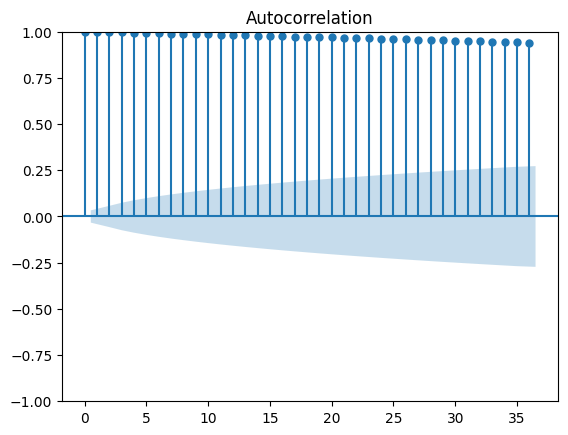

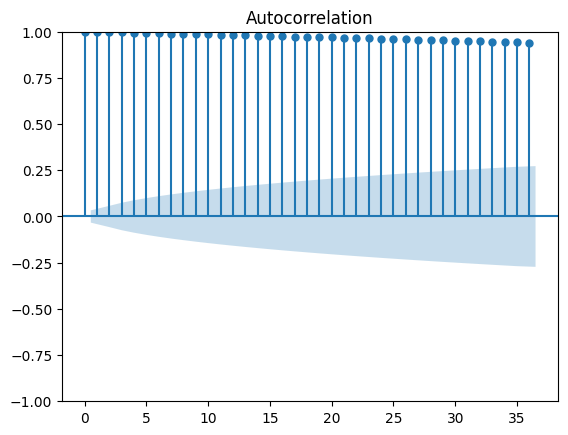

In [56]:
#importing modules
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df.value)

###  <font color="green"> La première différenciation et la deuxième différenciation pour améliorer la nature stationnaire</font> 

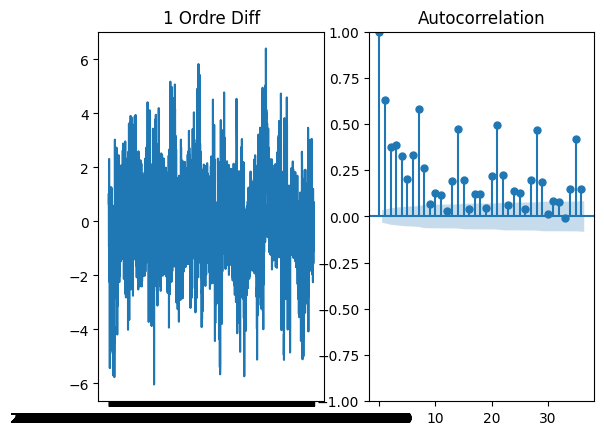

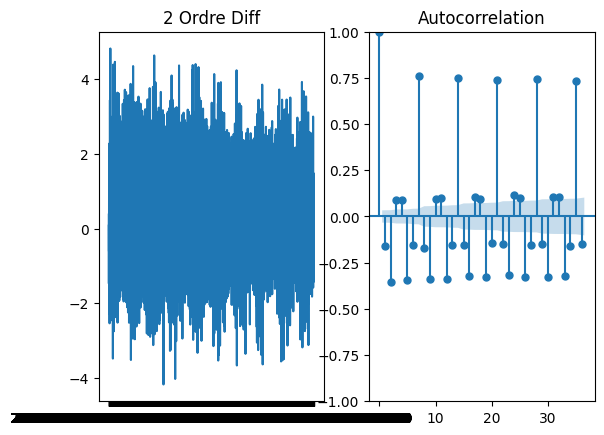

In [57]:
#1rst order differencing
f = plt.figure()
ax1=f.add_subplot(121)
ax1.set_title('1 Ordre Diff')
ax1.plot(df.value.diff())


ax2=f.add_subplot(122)
plot_acf(df.value.diff().dropna() , ax= ax2)
#plt.show()

#2nd order differencing
f = plt.figure()
ax1=f.add_subplot(121)
ax1.set_title('2 Ordre Diff')
ax1.plot(df.value.diff().diff())

ax2=f.add_subplot(122)
plot_acf(df.value.diff().diff().dropna() , ax= ax2)
plt.show()

###  <font color="green"> Vérifier la stationarité </font> 

In [58]:
# ADF Test
from statsmodels.tsa.stattools import adfuller
# perform augmented Dickey-Fuller test
#  H0: The time series is non-stationary.
#  HA: The time series is stationary.
# Suppose Test statistic: -3.0952105155554577
# Suppose P-value: 0.026909668130736933
# Since the p-value is not less than 0.05, we fail to reject the null hypothesis.

##################################################################
result_diff_1  = adfuller(df.value.diff().dropna())
p_value_1 = result_diff_1[1]
print ('p_value_Diff_order_1 = ' , p_value_1) # 1.17909511e-17

# Comparer la p-value à un seuil de significativité (par exemple, 0.05)
if p_value_1 <= 0.05:
    print("La série temporelle désaisonnalisé est stationnaire autour d'un trend (rejet de H0)")
else:
    print("La série temporelle désaisonnalisé n'est pas stationnaire autour d'un trend (absence de rejet de H0)")
###################################################################
result_diff_2  = adfuller(df.value.diff().diff().dropna())
p_value_2 = result_diff_2[1]

print ('p_value_Diff_order_2 = ' , p_value_2) # 1.114936294e-11   

# Comparer la p-value à un seuil de significativité (par exemple, 0.05)
if p_value_2 <= 0.05:
    print("La série temporelle désaisonnalisé est stationnaire autour d'un trend (rejet de H0)")
else:
    print("La série temporelle désaisonnalisé n'est pas stationnaire autour d'un trend (absence de rejet de H0)")

p_value_Diff_order_1 =  1.09316000133935e-09
La série temporelle désaisonnalisé est stationnaire autour d'un trend (rejet de H0)
p_value_Diff_order_2 =  2.9511413105063134e-28
La série temporelle désaisonnalisé est stationnaire autour d'un trend (rejet de H0)


### Alors on prend q=1 comme parametre de MA. Il suffit un seul differentiation pour rendre la série stationnaire.

###  <font color="green"> Déterminer p à partir de PACF </font> 

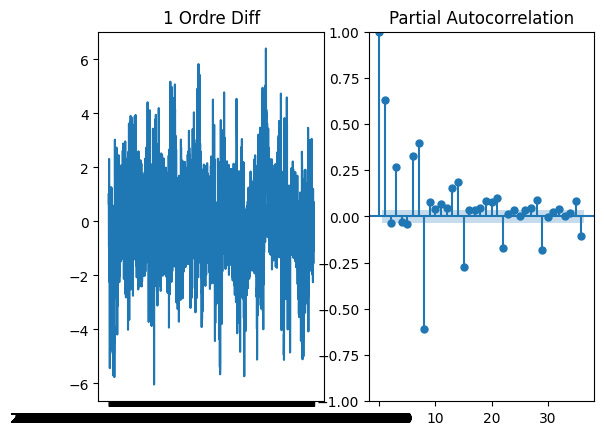

In [59]:
# # ####################### Auto Regression p: PACF #############
from statsmodels.graphics.tsaplots import plot_pacf

f = plt.figure()
ax1=f.add_subplot(121)
ax1.set_title('1 Ordre Diff')
ax1.plot(df.value.diff())
ax2=f.add_subplot(122)
plot_pacf(df.value.diff().dropna() , ax= ax2)
plt.show()